# Lab 4: Comparison of Binary Classifiers
Mark O'Brien 16184033

### A. Import Python Modules and Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from numpy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("./seeds.csv")

### B. EDA

In [3]:
df.head()

area  perimeter  compactness  length of kernel  width of kernel  \
0  15.26      14.84       0.8710             5.763            3.312   
1  14.88      14.57       0.8811             5.554            3.333   
2  14.29      14.09       0.9050             5.291            3.337   
3  13.84      13.94       0.8955             5.324            3.379   
4  16.14      14.99       0.9034             5.658            3.562   

   asymmetry coefficient  length of kernel groove  type  
0                  2.221                    5.220     1  
1                  1.018                    4.956     1  
2                  2.699                    4.825     1  
3                  2.259                    4.805     1  
4                  1.355                    5.175     1

In [4]:
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

Let's check for missing values in the dataset.

In [5]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

Since there are no missing values, we don't need to impute any values.

Let's check for outliers using boxplots of the features.

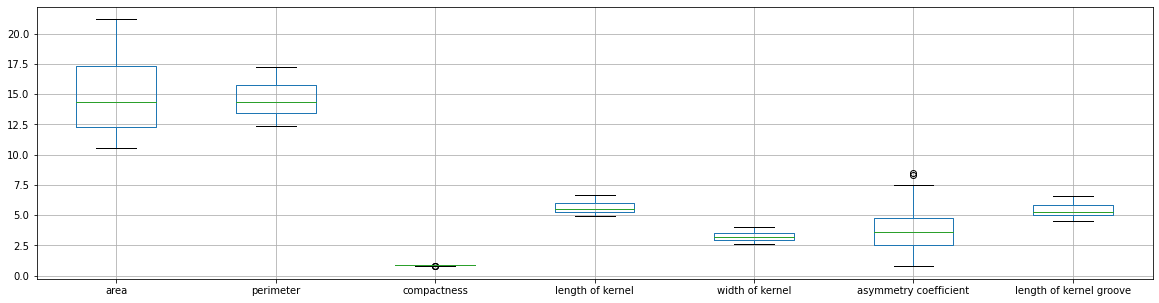

In [6]:
df.loc[:,'area':'length of kernel groove'].boxplot(figsize=(20,5))
plt.show()

There does not appear to be significant outliers in the features. We can also take a look at a statistical summary of the features.

In [7]:
df.describe()

area   perimeter  compactness  length of kernel  width of kernel  \
count  210.000000  210.000000   210.000000        210.000000       210.000000   
mean    14.847524   14.559286     0.870999          5.628533         3.258605   
std      2.909699    1.305959     0.023629          0.443063         0.377714   
min     10.590000   12.410000     0.808100          4.899000         2.630000   
25%     12.270000   13.450000     0.856900          5.262250         2.944000   
50%     14.355000   14.320000     0.873450          5.523500         3.237000   
75%     17.305000   15.715000     0.887775          5.979750         3.561750   
max     21.180000   17.250000     0.918300          6.675000         4.033000   

       asymmetry coefficient  length of kernel groove        type  
count             210.000000               210.000000  210.000000  
mean                3.700201                 5.408071    2.000000  
std                 1.503557                 0.491480    0.818448  
min                 0.765100                 4.519000    1.000000  
25%                 2.561500                 5.045000    1.000000  
50%                 3.599000                 5.223000    2.000000  
75%                 4.768750                 5.877000    3.000000  
max                 8.456000                 6.550000    3.000000

It seems that `StandardScaler` should be a suitable scaling technique for the features.

### C. Data Preparation

To create a binary classification problem, we will change the `type` feature so that it will give value 1 for type 2 and 0 for any other.

In [8]:
#one-hot `type`
df=pd.get_dummies(df, columns=['type'], drop_first=True)

In [9]:
#drop`type_3`
df.drop('type_3', axis=1, inplace=True)

In [10]:
#rename `type_2` to `type`
df=df.rename(columns={'type_2':'type'}, inplace = False)

In [11]:
#check if value counts are right
df['type'].value_counts()

0    140
1     70
Name: type, dtype: int64

In [12]:
#store a list with the names of all the predictors
names_all = [c for c in df if c not in ['type']]

Create the class to use in the preprocessing pipeline to put the names of the columns back

In [13]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

Create the class to be able to select a particular group of columns.

In [14]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

Create the preprocessing pipeline and apply `StandardScaler`.

In [15]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("columns", make_pipeline(
            ColumnSelector(columns=names_all),
            StandardScaler()
        ))
    ])
)

Separate the columns into the target feature `type` and the predictors and split into 80:20 training and test datasets.

In [16]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)
#80% training 20% test

### D. Grid Search for Best Parameters of Classifiers

First of all, we can train an SVM classifier.

In [17]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.976:
Best parameters:  {'svm__C': 100, 'svm__gamma': 1, 'svm__kernel': 'linear'}


In `GridSearchCV`, `n_jobs=-1` was used to use 100% of the CPU and `cv=5` was used because this is a small dataset. Using `cv`=10 obtained different results for the best parameters, however this would be more suitable for a larger dataset. The best paramaters were found to be: `C=100`, `gamma=1`, `kernel=linear`

Let's do the same for Random Forest

In [18]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.988:
Best parameters:  {'rf__max_depth': 4, 'rf__n_estimators': 10}


The best RF parameters were found to be: `max_depth=4`, `n_estimators=10`

### E. Compare Classifiers on Test Set

Let's evaluate the models using accuracy, precision, recall anf F1 scores. This will be done on a 1-100 scale so that the ROC curves can be made while ensuring the same for scale is used for all curves.

In [19]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [20]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [21]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

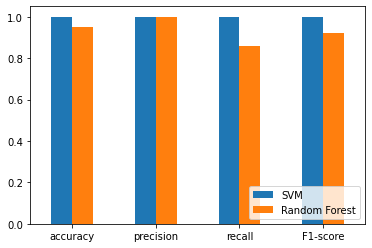

In [22]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

Both the SVM and random forest perform well and importantly, have high recall for type 2. From the bar charts, SVM would be picked as it performs better on accuracy, F1 score and, most importantly, recall.

We can now examine the ROC curves for the two classification techniques.

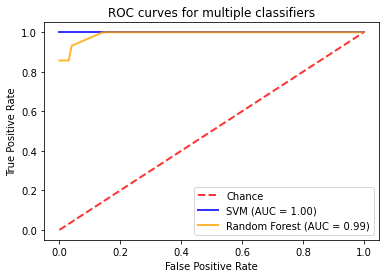

In [23]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

The curves confirm that both techniques perform much better than a random guess, with the SVM curve suggesting a better performance than the random forest curve.

### F. Third Classifier

We can now train a k Nearest Neighbors classification model.

In [24]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn', KNeighborsClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'knn__n_neighbors' : [1,2,3,4,5,6,7,8,9,10]
    }

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
knn_best_params = search.best_params_
knn_best_model = search.best_estimator_

Best CV score = 0.970:
Best parameters:  {'knn__n_neighbors': 2}


The pipeline suggests that the kNN algorithm works best with `k=2`.

Let's take a look at how kNN compares with SVM and RF.

In [25]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
knn_accuracy, knn_precision, knn_recall, knn_f1_score, knn_tpr, knn_auc = evaluate_model(X_test, y_test, knn_best_model)

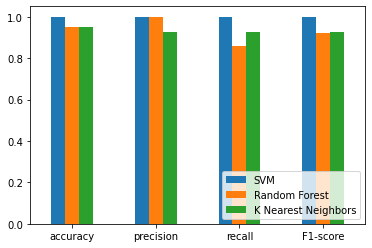

In [26]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
knn_metrics = np.array([knn_accuracy, knn_precision, knn_recall, knn_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'K Nearest Neighbors' : knn_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

kNN seems to work well with the data and performs better than RF in recall and F1-score. But since SVM performs better in all measures, we can choose SVM to train the final model.

We can also take a look at the ROC curve.

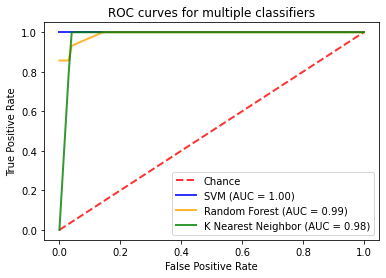

In [27]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, knn_tpr[0,:], lw=2, color='green', label='K Nearest Neighbor (AUC = %0.2f)' % (knn_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

The ROC curve proves that kNN performs much better than a random guess as well as SVM and RF.

### G. Train a Final Model

Finally, we can train an SVM model with all data we have rather than just the test data, assuming that the more data we have the better the model.

In [28]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)

We can also store this model on disk.

In [29]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))